# Predictions under epistemic uncertainty with p-boxes

Created by Elvis A. Eugene (eeugene@nd.edu)

The text and theory in this notebook have been adapted from 
- McClarren, Ryan G (2018). Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers, Chapter 12: Epistemic Uncertainties: Dealing with a Lack of Knowledge https://link.springer.com/chapter/10.1007/978-3-319-99525-0_11

The package *similaritymeasures* was developed by:
- Jekel, C. F., Venter, G., Venter, M. P., Stander, N., & Haftka, R. T. (2018). Similarity measures for identifying material parameters from hysteresis loops using inverse analysis. International Journal of Material Forming. https://doi.org/10.1007/s12289-018-1421-8
- More info: https://pypi.org/project/similaritymeasures/

A helper function from StackOverflow https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array is also used in this notebook

In [1]:
# Packages to interface with your operating system or Colab
import shutil
import sys
import os.path

# Check if similaritymeasures is available. If not, install it.
if not shutil.which("similaritymeasures"):
    !pip install similaritymeasures
else:
    print("similaritymeasures found! No need to install.")
    
# load libraries
import numpy as np
import matplotlib.pyplot as plt
import similaritymeasures as sm

# set random seed for numpy
np.random.seed(122)

## set plotting parameters
FIG_SIZE=(8,6)
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=FIG_SIZE)       # figure size

## Introduction
- Aleatory uncertainty: Uncertainty due to randomness, often modeled as a probability distribution of uncertain parameters
- Epistemic uncertainty: Uncertainty due to lack of knowledge about a system, for example, using an approximate model
 - Epistemic uncertainties are harder to quantify than aleatory uncertainties
 - In this notebook, epistemic uncertainty is modeled as a uniform distribution between the minimum and maximum values a parameter which we do not have enough knowledge about

## Objective: This notebook has code which will demonstrate adjusting p-boxes to make predictions under epistemic uncertainty
- Follows sections 12.1 - 12.4 of the text
- Figure 12.7 has been reproduced up to order of magnitude agreement

The deflection of a end-loaded cantilevered beam is given by:

\begin{equation}
y = \frac{4fL^3}{Ewh^3}
\end{equation}

In [2]:
def deflection_model(f,L,E,w,h):
    '''
    inputs
    f: force [N]
    L: length of beam [m]
    E: elastic modulus [Pa]
    w: width of beam [m]
    h: height of beam [m]
    
    outputs
    deflection of the beam [m]
    '''
    return (4*f*L**3)/(E*w*h**3)

L, w, and h are parameters with aleatoric uncertainty and follow the distributions:
\begin{equation}
L \sim \mathcal{N}(1,0.05)
\end{equation}

\begin{equation}
w \sim \mathcal{N}(0.01,0.0005)
\end{equation}

\begin{equation}
h \sim \mathcal{N}(0.02,0.0005)
\end{equation}

Deflection is estimated using simple random sampling

In [3]:
def estimate_deflection(E, f, n_samples):
    '''
    inputs
    E: elastic modulus [Pa]
    f: force [N]
    n_samples: number of samples for estimator
    
    outputs
    y: estimated deflection [m]
    '''
    
    mu_L = 1 # [m]
    sig_L = 0.05 # [m]
    
    mu_w = 0.01 # [m]
    sig_w = 0.0005 # [m]
    
    mu_h = 0.02 # [m]
    sig_h = 0.0005 # [m]
    
    y = 0 # [m] 
    
    for i in range(n_samples):
        # sample parameters with aleatoric uncertainty 
        L = np.random.normal(loc=mu_L,scale=sig_L)
        w = np.random.normal(loc=mu_w,scale=sig_w)
        h = np.random.normal(loc=mu_h,scale=sig_h)
        
        # cumulative expected value of deflection
        y += deflection_model(f,L,E,w,h)
    # end loop over n_samples
    
    # calculated expected value of deflection
    y = y/n_samples
    
    return y

Observations of deflection were simulated to compare it's CDF to the p-box and calculate model discrepancy d

In [4]:
def observe_deflection(E, f):
    
    mu_L = 1 # [m]
    sig_L = 0.05 # [m]
    
    mu_w = 0.01 # [m]
    sig_w = 0.0005 # [m]
    
    mu_h = 0.02 # [m]
    sig_h = 0.0005 # [m]
    
    stdev_obs_err = 0.01
    
    y = 0 # [m] 
    
    # sample parameters with aleatoric uncertainty 
    L = np.random.normal(loc=mu_L,scale=sig_L)
    w = np.random.normal(loc=mu_w,scale=sig_w)
    h = np.random.normal(loc=mu_h,scale=sig_h)

    y = deflection_model(f,L,E,w,h)
    
    # calculated observed deflection
    y += np.random.normal(loc=0,scale=stdev_obs_err)
    
    return y    

CDFs were plotted using the following function

In [5]:
def plot_cdf(fig,ax,y,label=None,color='k',alpha=0.3):
    
    # sort y in ascending order
    asc_idx = np.argsort(y)
    
    # get cdf of y
    y_cdf = y[asc_idx]
    
    # calculate ranks for cdf
    cdf = np.linspace(0,1,len(y_cdf))
    
    # plot 
    ax.step(y_cdf,cdf,label=label,color=color,alpha=alpha)
    
    return y_cdf, cdf


### Horsetail plots
For a fixed values of the epistemically uncertain parameter, i.e. elastic modulus E, a CDF of the QoI, i.e., deflection y is produced. Sampling from a uniform distribution between the values of the epistemically uncertain parameter E produces one CDF per sample, which when plotted, gives a horsetail plot

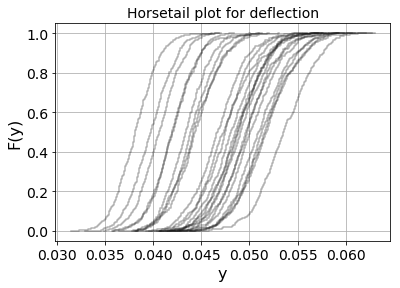

In [6]:
## main 
# set interval for elastic modulus
E_low = 69e9
E_high = 100e9

# force
f = 75 # N

# number of samples for mc estimation
n_mc_samples = 10

# number of points for cdf calculation
n_cdf_points = 500

# number of samples of E with epistemic uncertainty
n_E_samples = 25

# array to save results
# each row corresponds to one realization of E
y = np.zeros((n_E_samples,n_cdf_points))
# y_cdf = np.zeros((n_E_samples,n_cdf_points))

# plot cdf
fig, ax = plt.subplots()

for i in range(n_E_samples):
    # sample E which containts epistemic uncertainty
    E = np.random.uniform(E_low,E_high)
    for j in range(n_cdf_points):
        y[i,j] = estimate_deflection(E,f,n_mc_samples)
    # end cdf calculation
    y[i,:], not_used = plot_cdf(fig,ax,y[i,:],label='low',color='k')
# End loop over samples of E

plt.title('Horsetail plot for deflection')
plt.xlabel('y')
plt.ylabel('F(y)')
plt.grid(True)
plt.show()

### p-box
The upper and lower bounds of the CDF in the horsetail plot, $\overline{P}$ and $\underline{P}$ respectively, enclose an area between them known as the probability box or p-box. The p-box represents a range of CDFs that can represent the system.

In [7]:
def plot_pbox(fig,ax,y_cdf,ht_min_adj=None,ht_max_adj=None,obs=None,obs_cdf=None,color='k'):
    '''
    inputs:
    fig: matplotlib figure object
    ax: matplotlib axis object corresponding to fig
    y_cdf: simulations of the QoI at multiple realizations of the epistemically uncertain parameter, 2D numpy array
    ht_min_adj: adjusted lower bound of the pbox, 1D numpy array
    ht_max_adj: adjusted upper bound of the  pbox, 1D numpy array
    obs: experimental observations, 1D numpy array
    obs_cdf: CDF of experimental observatinos, 1D numpy array
    color: line color for plotting
    
    outputs:
    ht_top: top boundary of p-box, 1D numpy array
    ht_bottom: bottom boundary of p-box, 1D numpy array
    ht_min: lower/left boundary of p-box, 1D numpy array 
    ht_max: upper/right boundary of p-box, 1D numpy array  
    cdf_top: plot vector corresponding to ht_top, 1D numpy array 
    cdf_bottom: plotting vector corresponding to ht_bottom, 1D numpy array
    cdf_minmax: plotting vector corresponding to ht_min and ht_max, 1D numpy array
    '''
    
    # arrays to save p-box boundaris
    ht_top = np.zeros(y_cdf.shape[1])
    ht_bottom = np.zeros(y_cdf.shape[1])
    ht_min = np.zeros(y_cdf.shape[1])
    ht_max = np.zeros(y_cdf.shape[1])
    
    # top and bottom boundary of p-box
    ht_top = y_cdf[:,-1]
    ht_bottom = y_cdf[:,0]
    
    # lower and upper bound of p-box
    for i in range(y_cdf.shape[1]):
        ht_min[i] = np.amin(y_cdf[:,i])
        ht_max[i] = np.amax(y_cdf[:,i])
    
    # cdf vectors for plotting
    cdf_top = np.ones(len(y_cdf))
    cdf_bottom = np.zeros(len(y_cdf))
    cdf_minmax = np.linspace(0,1,y_cdf.shape[1])
    
    # plot
    ax.step(ht_top,cdf_top,color=color)
    ax.step(ht_bottom,cdf_bottom,color=color)
    ax.step(ht_min,cdf_minmax,color=color)
    ax.step(ht_max,cdf_minmax,color=color)
    
    # plot adjusted p-boxes
    if (type(obs)==np.ndarray):
        ax.step(obs,obs_cdf,color='r',label='Observations')
    
    if (type(ht_min_adj)==np.ndarray):
        ax.step(ht_min_adj,cdf_minmax,color=color,linestyle=':',label='Adjusted p-box')
    
    if (type(ht_max_adj)==np.ndarray):
        ax.step(ht_max_adj,cdf_minmax,color=color,linestyle=':')
        
    plt.plot([],[],'k',label='p-box')
    plt.title('p-box for deflection')
    plt.xlabel('y')
    plt.ylabel('F(y)')
    plt.grid(True)
    plt.legend()
    
        
    return ht_top, ht_bottom, ht_min, ht_max, cdf_top, cdf_bottom, cdf_minmax

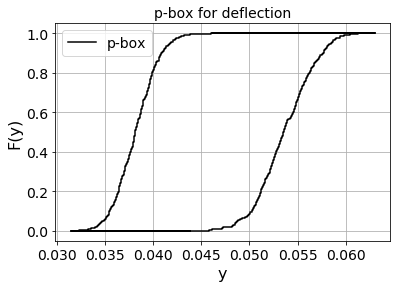

In [8]:
fig,ax = plt.subplots()
ht_top, ht_bottom, ht_min, ht_max, cdf_top, cdf_bottom, cdf_minmax = plot_pbox(fig,ax,y)

### Validation metric d
Using 10 observations at f = 75 N, the CDF of the observations is compared with the p-box to give the validation metric d

The validation metric d generalizes the discrepancy between experimental observations and the p-box and is defined as:

\begin{equation}
d(F_{sim} - F_{obs}) = \int_{-\infty}^{\infty} = D(\overline{P},\underline{P},F_{obs}(Q))dQ
\end{equation}

\begin{equation}
    D(\overline{P},\underline{P},F_{obs}(Q)) = 
    \left\{
                \begin{array}{ll}
                  0 & F_{obs}(Q) \in [\overline{P}(Q),\underline{P}(Q)] \\
                  min(|F_{obs}(Q)-\overline{P}(Q)|,|F_{obs}(Q)-\underline{P}(Q)|)
                  & F_{obs}(Q) \notin [\overline{P}(Q),\underline{P}(Q)] \\
                \end{array}
              \right.
\end{equation}

where Q is the QoI and F(Q) is the CDF of the QoI

The p-box for the prediction is then defined as:
\begin{equation}
\underline{P}_{pred} (Q) = \underline{F}(Q-d) \qquad \overline{P}_{pred} (Q) = \overline{F}(Q+d)
\end{equation}

Alternately, one could calculate the portion of d to the left and right of the p-box and asymmetrically adjust the p-box:
\begin{equation}
d_{left}(F_{sim},F_{obs}) = d(\underline{P}(Q),F_{obs}(Q))
\end{equation}

\begin{equation}
d_{right}(F_{sim},F_{obs}) = d(\overline{P}(Q),F_{obs}(Q))
\end{equation}

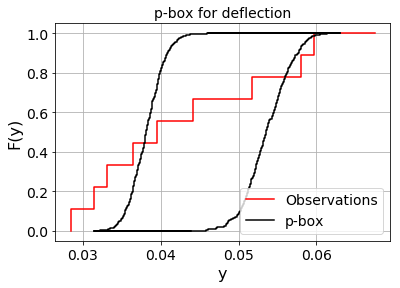

In [9]:
# perform 10 experiments
n_exp = 10
obs = np.zeros(n_exp)
for i in range(n_exp):
    E = np.random.uniform(E_low,E_high)
    obs[i] = observe_deflection(E,f)

fig,ax = plt.subplots()
obs, obs_cdf = plot_cdf(fig,ax,obs,label='Observations',color='r',alpha=1)
ht_top, ht_bottom, ht_min, ht_max, cdf_top, cdf_bottom, cdf_minmax = plot_pbox(fig,ax,y)

In [10]:
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    '''
    inputs: 
    array : array to search for closest scalar value in, 1D numpy array 
    value: scalar value to search for in array
    
    outputs:
    idx: index of arr whose element is closest to value
    arr[idx]: element in array closest to value
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [11]:
def calc_d_left(ht_min,cdf_minmax,obs,obs_cdf):
    '''
    inputs:
    ht_min: lower/left boundary of p-box, 1D numpy array 
    cdf_minmax: plotting vector corresponding to ht_min and ht_max, 1D numpy array
    obs: experimental observations, 1D numpy array
    obs_cdf: CDF of experimental observatinos, 1D numpy array
    
    outputs:
    d_left: left sided model discrepancy 
    '''
    
    # find the intersection between cdf of observations and left P-box
    for i in range(len(obs)):
        # find the nearest value to the observation in the cdf
        near_idx, near_val = find_nearest(cdf_minmax,obs_cdf[i])
        diff = ht_min[near_idx] - obs[i]
        
        if (diff<0) and (near_idx>0) and (i > 0):
            ht_min_int_idx = near_idx
            obs_int_idx = i
            if False:
                print('ht_min_int_idx=',ht_min_int_idx)
                print('obs_int_idx=',obs_int_idx)
            break
        else:
            ht_min_int_idx = 0
            obs_int_idx = 0
    # END find the intersection between cdf of observations and left P-box
    
    ## define curves bounding d_left
    # CDF of observations/experimental data
    x_obs = obs[0:obs_int_idx]
    y_obs = obs_cdf[0:obs_int_idx]
    exp_data = np.zeros((len(x_obs), 2))
    exp_data[:, 0] = x_obs
    exp_data[:, 1] = y_obs
    # left p-box boundary/simulated data
    x_p_left = ht_min[0:ht_min_int_idx]
    y_p_left = cdf_minmax[0:ht_min_int_idx]
    sim_data = np.zeros((len(x_p_left)+1, 2))
    sim_data[0,0] = 0
    sim_data[0,1] = 0
    sim_data[1:, 0] = x_p_left
    sim_data[1:, 1] = y_p_left
    
    # calculate d_left i.e. area under the curve
    d_left = sm.area_between_two_curves(exp_data, sim_data)
    
    return d_left

In [12]:
def calc_d_right(ht_max,cdf_minmax,obs,obs_cdf):
    '''
    inputs:
    ht_max: upper/right boundary of p-box, 1D numpy array 
    cdf_minmax: plotting vector corresponding to ht_min and ht_max, 1D numpy array
    obs: experimental observations, 1D numpy array
    obs_cdf: CDF of experimental observatinos, 1D numpy array
    
    outputs:
    d_left: left sided model discrepancy 
    '''
    
    # find the intersection between cdf of observations and left P-box
    for i in range(len(obs)):
        # find the nearest value to the observation in the cdf
        near_idx, near_val = find_nearest(cdf_minmax,obs_cdf[i])
        diff = ht_max[near_idx] - obs[i]
        
        if (diff<0) and (near_idx>0) and (i > 0):
            ht_max_int_idx = near_idx
            obs_int_idx = i
            if False:
                print('ht_max_int_idx=',ht_max_int_idx)
                print('obs_int_idx=',obs_int_idx)
            break
        else:
            ht_max_int_idx = 0
            obs_int_idx = 0
    # END find the intersection between cdf of observations and left P-box
    
    ## define curves bounding d_left
    # CDF of observations/experimental data
    x_obs = obs[obs_int_idx:]
    y_obs = obs_cdf[obs_int_idx:]
    exp_data = np.zeros((len(x_obs), 2))
    exp_data[:, 0] = x_obs
    exp_data[:, 1] = y_obs
    # left p-box boundary/simulated data
    x_p_right = ht_max[ht_max_int_idx:]
    y_p_right = cdf_minmax[ht_max_int_idx:]
    sim_data = np.zeros((len(x_p_right), 2))
    sim_data[:, 0] = x_p_right
    sim_data[:, 1] = y_p_right
    
    # calculate d_left i.e. area under the curve
    d_right = sm.area_between_two_curves(exp_data, sim_data)
    
    return d_right

In [13]:
d_left = calc_d_left(ht_min,cdf_minmax,obs,obs_cdf)
d_right = calc_d_right(ht_max,cdf_minmax,obs,obs_cdf)
d_total = d_left+d_right

print('d = {0:.4f}'.format(d_total))
print('d_left = {0:.4f}'.format(d_left))
print('d_right = {0:.4f}'.format(d_right))


d = 0.0021
d_left = 0.0013
d_right = 0.0008


The predicted delfection of the beam when a force $\mathrm{f_{new}}$ = 100 N is applied is given by computing the p-box at $\mathrm{f_{new}}$ and symmetrically or asymmetrically adjusting the p-box

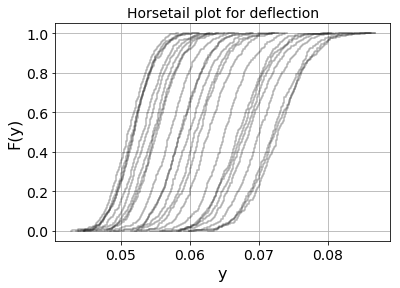

In [14]:
# calculate p-box at 100 N
f_new = 100 # [N]

# array to save results
# each row corresponds to one realization of E
y_pred = np.zeros((n_E_samples,n_cdf_points))
# y_cdf = np.zeros((n_E_samples,n_cdf_points))

# plot cdf
fig2, ax2 = plt.subplots()

for i in range(n_E_samples):
    # sample E which containts epistemic uncertainty
    E = np.random.uniform(E_low,E_high)
    for j in range(n_cdf_points):
        y_pred[i,j] = estimate_deflection(E,f_new,n_mc_samples)
    # end cdf calculation
    y_pred[i,:], not_used = plot_cdf(fig2,ax2,y_pred[i,:],label='low',color='k')
# End loop over samples of E

plt.title('Horsetail plot for deflection')
plt.xlabel('y')
plt.ylabel('F(y)')
plt.grid(True)
plt.show()

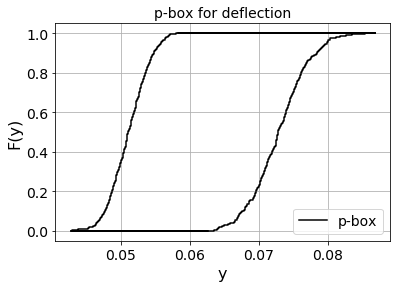

In [15]:
# plot and extract p-box arrays
fig,ax = plt.subplots()
ht_top_pred, ht_bottom_pred, ht_min_pred, ht_max_pred, cdf_top_red, cdf_bottom_pred, cdf_minmax_pred =\
plot_pbox(fig,ax,y_pred)

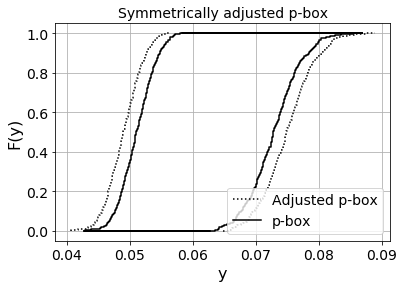

In [16]:
# symmetric adjustment of p-box
ht_min_sym = ht_min_pred-d_total
ht_max_sym = ht_max_pred+d_total

fig,ax = plt.subplots()
p = plot_pbox(fig,ax,y_pred,ht_min_adj=ht_min_sym,ht_max_adj=ht_max_sym)
plt.title('Symmetrically adjusted p-box');

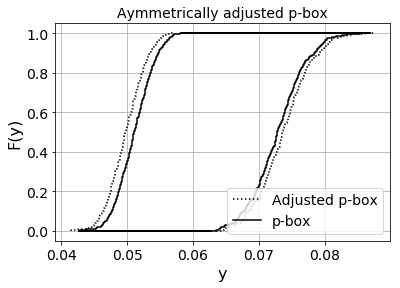

In [17]:
# asymmetric adjustment of p-box
ht_min_asym = ht_min_pred - d_left
ht_max_asym = ht_max_pred + d_right

fig,ax = plt.subplots()
p = plot_pbox(fig,ax,y_pred,ht_min_adj=ht_min_asym,ht_max_adj=ht_max_asym)
plt.title('Aymmetrically adjusted p-box');